In [16]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def load_image(file_name: str): 
    """
    load image(.png) and convert into np.ndarray
    """

    image = cv2.imread(file_name)
    image = image[..., ::-1] # BGR -> RGB
    image = image / 255.0 # float64
    image = image.astype('float32') # float64 -> float32
    return image

def load_dir(dir_name: str):
    """
    load all images in the dir 
    """
    output = []
    path_in_dir = glob.glob(dir_name + "/*.png")
    for path in path_in_dir:
        image = load_image(path)
        output.append(image)
    output = np.array(output)
    return output

def load_each_set(set_name: str):
    """
    load each dataset (train, val and test)
    """
    x = []
    y = []
    for label in [0, 1]:
        dataset = load_dir('Dataset/' + set_name + '/' + str(label) +'/')
        for data in dataset:
            x.append(data)
            y.append(np.array([label]).astype(np.uint8))
    return np.array(x), np.array(y)

def load_all_set():
    """
    load all dataset
    """
    x_train, y_train = load_each_set('train')
    x_val, y_val = load_each_set('val')
    x_test, y_test = load_each_set('test') 

    return x_train, y_train, x_val, y_val, x_test, y_test

def plot_image(image: np.ndarray):
    plt.figure(figsize=(7,7))
    plt.axis('off')
    plt.imshow(image, cmap="gray")

(224, 224, 3)
<class 'numpy.ndarray'>
float32
0.9647059 0.0


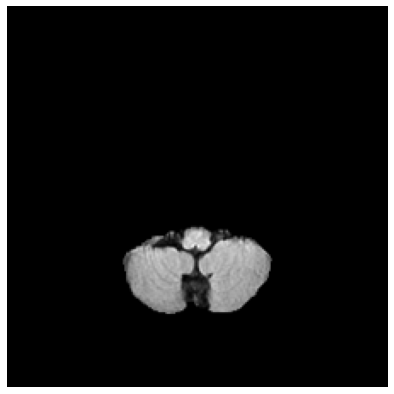

In [18]:
image = load_image("Dataset/train/0/1.png")
print(image.shape)
print(type(image))
print(image.dtype)
print(image.max(), image.min())
plot_image(image)

(224, 224, 3)
<class 'numpy.ndarray'>
float32
1.0 0.0


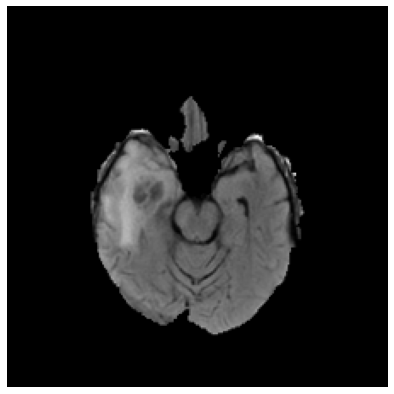

In [19]:
train_neg_images =load_dir("Dataset/train/0/")
image = train_neg_images[0]
print(image.shape)
print(type(image))
print(image.dtype)
print(image.max(), image.min())
plot_image(image)

4486

(224, 224, 3)
<class 'numpy.ndarray'>
float32
1.0 0.0
<class 'numpy.ndarray'>
uint8


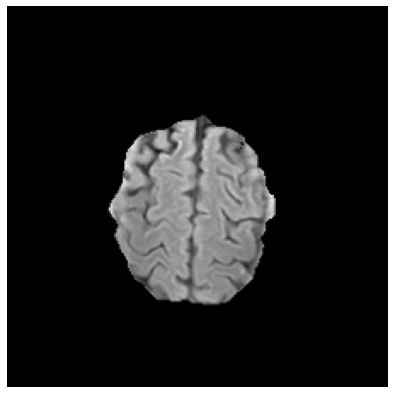

In [21]:
x_train, y_train = load_each_set('train')
image = x_train[0]
label = y_train[0]
print(image.shape)
print(type(image))
print(image.dtype)
print(image.max(), image.min())
print(type(label))
print(label.dtype)
plot_image(image)

In [29]:
from torchvision import models, transforms
import torch
import torch.nn as nn

from utils import load_image

model_name = 'resnet50'
dir_name = f'result/{model_name}'
model_path = f'{dir_name}/{model_name}.pth'

def extract(target, inputs):
    feature = None

    def forward_hook(module, inputs, outputs):
        global features

        features = outputs.detach().clone()

    handle = target.register_forward_hook(forward_hook)

    model.eval()
    model(inputs)

    handle.remove()
    
    return features

device = torch.device("cuda")

model = models.resnet50(pretrained=False)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Sequential(nn.Linear(2048,1, bias=True),  nn.Sigmoid())

model = model.to(device)
model.load_state_dict(torch.load(model_path))

target_module = model.layer1[2].relu

inputs = load_image('result/resnet50/incorrect_mri/0/9.png')
transform = transforms.Compose([
    transforms.ToTensor(),
])

inputs = transform(inputs)
inputs = inputs.unsqueeze(0).to(device)

features = extract(target_module, inputs)
print(features.shape)

torch.Size([1, 256, 56, 56])


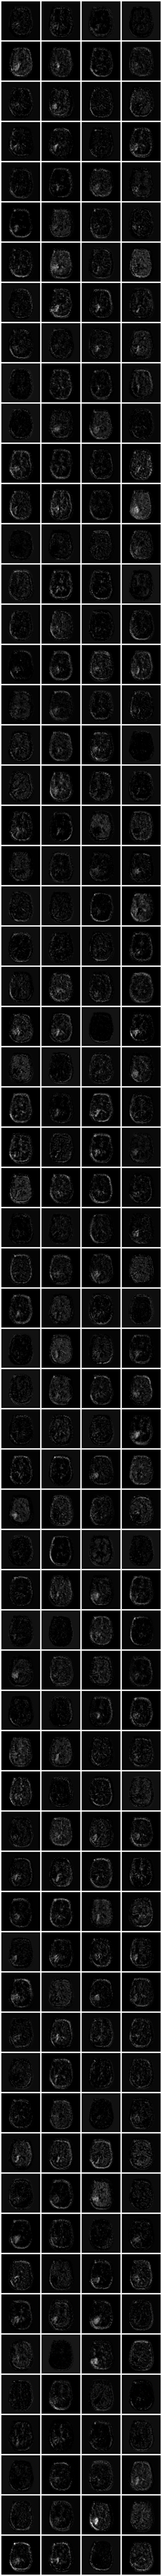

In [31]:
import torchvision

def feature_to_img(feature, nrow=4):

    feature = feature.unsqueeze(1)

    img = torchvision.utils.make_grid(feature.cpu(), nrow=nrow, normalize=True, pad_value=1)

    img = transforms.functional.to_pil_image(img)
    
    new_w = 500
    new_h = int(new_w*img.height / img.width)
    img = img.resize((new_w, new_h))

    return img

img = feature_to_img(features[0][:256])
img